In [4]:
# import subprocess

# packages = ['geemap', 'geopandas',
#             'shapely', 'requests', 
#             'osgeo', 'rasterio', 'numpy',
#             'sklearn', 'fiona', 'pyproj',
#             'matplotlib', 'pandas',
#             'seaborn','geocube', 'os']

# for package in packages:
#     try:
#         __import__(package)
#     except ImportError:
#         subprocess.check_call(['pip', 'install', package])

import neccessary libaries

In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import json
import rasterio as rio
import shapely
import fiona
import warnings

warnings.filterwarnings('ignore')

In [6]:
# load the boundary shapefile for Area of Intrest (AOI)
study_area = gpd.read_file('data/tocantins.shp')
study_area.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,33,BRA,Brazil,27,TO,Estado,State,None,None,"POLYGON ((-48.35310 -5.17391, -48.32085 -5.201..."


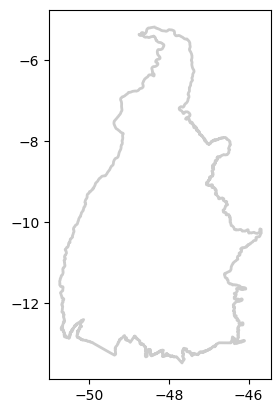

In [7]:
study_area.plot( linewidth=2, color='white', edgecolor='0.8');

The independent variables that will be use in building this model are in raster format, they will be extracted from google earth engine and downloaded uisng geemap and ee API.

In [8]:
# import google eath enigne libary for python
import io
import geemap
import ee

In [9]:
# Autheticate the Google earth engine ee login
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

Define ee boundary

In [10]:
# convert the boundary shapefile to ESPG 4326
boundary = study_area

# define a helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf):
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

# create the ee object
feature_cls = ee.Geometry.MultiPolygon(shp_to_ee_fmt(boundary))

Generate Slope and DEM

In [11]:
#load SRTM data from google earth engine
srtm = ee.Image('CGIAR/SRTM90_V4')

# Generate individual raster data
elevation = srtm.select('elevation')
slope = ee.Terrain.slope(elevation)

Generate LULC

In [12]:
# load ESA 2020 World wide 10m land cover  data form google earth
collection = (
    ee.ImageCollection('ESA/WorldCover/v200')
    .filterBounds(feature_cls)
)

landcover = collection.first()

# collection.aggregate_array('system:index').getInfo()

Generate NDVI, NDMI BSI

In [13]:
# select Landsat 8 collection for the spectal indices
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA") \
    .filterBounds(feature_cls) \
    .filterDate('2021-01-01', '2022-12-31') \
    .sort('CLOUD_COVER') \
    .median()


# Calculate NDVI
ndvi = l8.normalizedDifference(['B5', 'B4'])

# Calculate NDMI
ndmi = l8.normalizedDifference(['B5', 'B6'])

# Calculate BSI
bsi = l8.expression(
    '((SWIR2 + RED) - (SWIR1 + NIR)) / ((SWIR2 + RED) + (SWIR1 + NIR))',
    {
        'SWIR1': l8.select('B6'),
        'SWIR2': l8.select('B6'),
        'NIR': l8.select('B5'),
        'RED': l8.select('B4')
    }
)

Generate LST and SMI

Generate Temperature and Rainfall data

In [14]:
# Define date range
start_date = '2012-01-01'
end_date = '2022-12-31'

# Load CHIRP precipitation data
rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterBounds(feature_cls) \
    .filterDate(start_date, end_date) \
    .select('precipitation') \
    .sum()

# Load average temperature data
temp = ee.ImageCollection('NOAA/CFSV2/FOR6H') \
    .filterBounds(feature_cls) \
    .filterDate(start_date, end_date) \
    .select('Temperature_height_above_ground') \
    .mean()

soil Type

Get Global SOC datasets

In [22]:
# Global SOC soc dataset
soc= ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")\
        .select('b30')

soc = soc.multiply(0.005)

clip all images to features

In [23]:
# clip all the images load to the study area
elevation_clip  = elevation.clip(feature_cls)
slope_clip = slope.clip(feature_cls)
landcover_clip = landcover.clip(feature_cls)
rainfall_clip = rainfall.clip(feature_cls)
temp_clip = temp.clip(feature_cls)
ndvi_clip = ndvi.clip(feature_cls)
bsi_clip = bsi.clip(feature_cls)
soc_clip = soc.clip(feature_cls)

set Visualization Parameters

In [24]:
# visualization parameters
elevation_viz = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}

slope_viz = {
    'min': 0,
    'max': 60,
    'palette': ['brown', 'yellow', 'green']
}

landcover_viz = {
  'min': 0,
  'max': 100,
  'palette': [
      'FC6D26', 'FCAF17', 'E8EB45', '34B334', '4C7EAF',
      'B05AFF', 'A56F37', '914D25', 'BFC0C3', 'FFFFFF',
  ]
}

rainfall_viz = {
    'min': 0,
    'max': 300,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}


temp_viz = {
    'min': 0,
    'max': 310.0,
    'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}


bsi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green']
}


soc_viz = {
  'min': 0.0,
  'max': 120.0,
  'palette': [
    "ffffa0","f7fcb9","d9f0a3","addd8e","78c679","41ab5d",
    "238443","005b29","004b29","012b13","00120b",
  ]
}

Add Data to Map layer to visualize all data

In [25]:
#instatiate Map()
Map = geemap.Map()
# Add all image layer to a basemap
Map.addLayer(elevation_clip, elevation_viz, 'Elevation')
Map.addLayer(slope_clip, slope_viz, 'Slope')
Map.addLayer(landcover_clip, landcover_viz, 'Landcover')
Map.addLayer(rainfall_clip, rainfall_viz, 'Rainfall')
Map.addLayer(temp_clip, temp_viz, 'Temperature')
Map.addLayer(ndvi_clip, ndvi_viz, 'NDVI')
Map.addLayer(bsi_clip, bsi_viz, 'BSI')
Map.addLayer(soc_clip, soc_viz,'soc organic carbon content in x 5 g / kg')

# set map center object
Map.centerObject(elevation_clip, 8)

# call the geemap Map object
Map

Map(center=[-10.14095118527972, -48.32883664541774], controls=(WidgetControl(options=['position', 'transparent…

Export Data to local database

In [19]:
# from utils import export_ee_image

# export_ee_image_list(image_list, image_name,out_folder,region,scale)


In [20]:
from utils import generate_random_point
from utils import extract_raster_value


Reproject all data to the projected crs

In [21]:
#reproject th bounday shapefile
pro_boundary = study_area.to_crs(epsg=projected_crs)
print(pro_boundary.crs)

NameError: name 'projected_crs' is not defined

In [ ]:
#reproject the sampling points shapefiles
pro_sampling_points = sampling_points.to_crs(epsg=projected_crs)
print(pro_sampling_points.crs)

epsg:32721


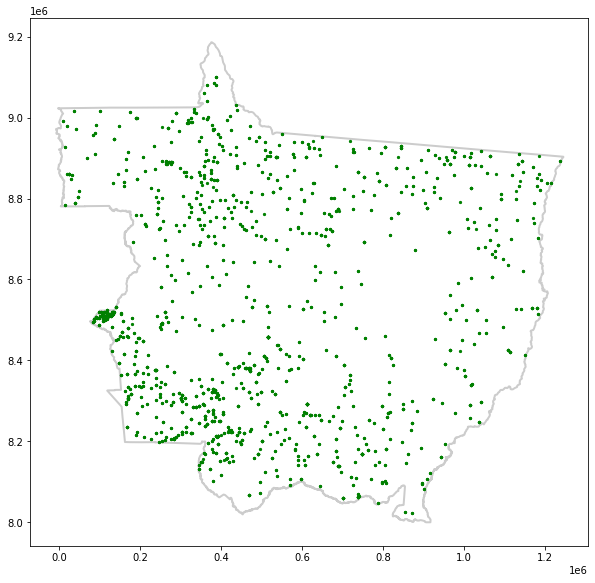

In [ ]:
#plot reprojected raster
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
ax = pro_boundary.plot(ax=ax, linewidth=2, color='white', edgecolor='0.8')
pro_sampling_points.plot(ax=ax, markersize=5, color='green');

In [ ]:
from osgeo import gdal

In [ ]:
#reproject all images
os.chdir(cwd) # change to current working folder
input_files = ['slope.tif', 'elevation.tif', 'landcover.tif', ]
output_res = (90, 90)

for file in input_files:
    input_file = os.path.join(cwd, file)
    output_file = os.path.join(cwd, f'projected_{file}')
    warp_options = gdal.WarpOptions(format='GTiff', xRes=output_res[0], yRes=output_res[1])
    gdal.Warp(output_file, input_file, options=warp_options)

In [ ]:
import rasterio

Now, Load the Reprojected data into the Notebook and check the crs 

In [ ]:
# Load the slope, elevation, and land use rasters
image = rasterio.open(os.path.join(cwd,'slope.tif'),


In [ ]:
# print(proj_slope.crs), print(proj_elevation.crs), print(proj_slope.crs)

### Now lets reproject our point data to the raster crs, extarct the values and also plot the raster data.

Since the raster crs is not mathcing with our training data points, to extract the values of each rasterdata to the points, we need to reproject the raster dataset to the flood dataset local datum (epsg:4326), this will make all the data overlay on each other.

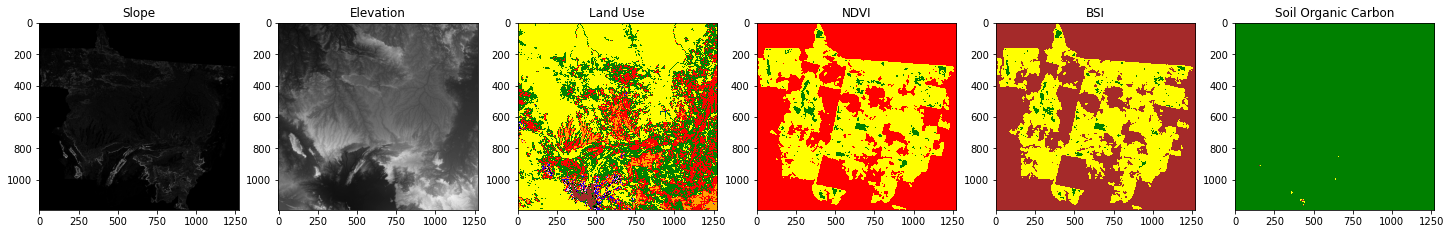

In [ ]:
from matplotlib.colors import ListedColormap

# Get the raster data arrays and the coordinate reference systems (CRS) for each dataset
slope_data = slope.read(1)
elevation_data = elevation.read(1)
landuse_data = land_use.read(1)
ndvi_data = ndvi.read(1)
bsi_data = bsi.read(1)
soc_data = soc.read(1)

# Create a figure object and add three subplots
fig, axs = plt.subplots(1,6, figsize=(25, 10))

# Plot each raster dataset on a subplot
axs[0].imshow(slope_data, cmap='Greys_r')
axs[0].set_title('Slope')
axs[1].imshow(elevation_data, cmap='Greys_r')
axs[1].set_title('Elevation')
axs[2].imshow(landuse_data, cmap=ListedColormap([
      'yellow', 'green', 'red', 'orange', 'blue',
      'purple', 'pink', 'black', 'green', 'brown',
  ]))
axs[2].set_title('Land Use')
axs[3].imshow(ndvi_data, cmap=ListedColormap(['red', 'yellow', 'green']))
axs[3].set_title('NDVI')
axs[4].imshow(bsi_data, cmap=ListedColormap(['green', 'yellow', 'brown']))
axs[4].set_title('BSI')

axs[5].imshow(soc_data, cmap=ListedColormap(['green', 'yellow', 'brown']))
axs[5].set_title('soc Organic Carbon')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

Extract all the values from each raster dataset to the flood dataset
 To understand what each values of LULC represent got to https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200#bands

### Exploratory Data Analysis

Now lets explore our dataset, we will check for missing value, plor our data and also check the correlation between the dataset

In [ ]:
# read the dataset to view the addeded columns
sampling_points.head()

,SOC_gkg,slope,elevation,land_use,ndvi,bsi,geometry,SOC
0,1.3,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
2,0.5,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
3,2.0,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
4,5.5,0.222091,241.0,10.0,0.068141,-0.035617,POINT (-51.30944 -14.21444),1.0
5,20.0,2.585801,468.0,30.0,0.477742,-0.393338,POINT (-52.80306 -14.51194),3.0


In [ ]:
#check that there is no no data values in the dataset
print(sampling_points.head().isnull().sum())

SOC_gkg      0
slope        0
elevation    0
land_use     0
ndvi         0
bsi          0
geometry     0
SOC          0
dtype: int64


In [ ]:
#describe the dataset
sampling_points.describe()

,SOC_gkg,slope,elevation,ndvi,bsi,SOC
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,9.710639,1.027890,302.930242,0.188505,-0.165431,2.044817
std,11.171494,1.304667,134.114918,0.155726,0.128735,0.751307
min,0.100000,0.000000,97.000000,-0.014922,-0.669856,0.000000
25%,3.000000,0.314477,211.000000,0.059455,-0.238349,2.000000
50%,6.000000,0.697998,279.000000,0.150451,-0.138097,2.000000
75%,12.575000,1.203847,369.000000,0.280983,-0.082701,2.000000
max,122.400000,15.156256,864.000000,0.770654,0.031722,8.000000


In [ ]:
sampling_points_2 = sampling_points[sampling_points.SOC_gkg>0]
sampling_points_2.describe()

,SOC_gkg,slope,elevation,ndvi,bsi,SOC
count,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000,2566.000000
mean,9.710639,1.027890,302.930242,0.188505,-0.165431,2.044817
std,11.171494,1.304667,134.114918,0.155726,0.128735,0.751307
min,0.100000,0.000000,97.000000,-0.014922,-0.669856,0.000000
25%,3.000000,0.314477,211.000000,0.059455,-0.238349,2.000000
50%,6.000000,0.697998,279.000000,0.150451,-0.138097,2.000000
75%,12.575000,1.203847,369.000000,0.280983,-0.082701,2.000000
max,122.400000,15.156256,864.000000,0.770654,0.031722,8.000000


<AxesSubplot:>

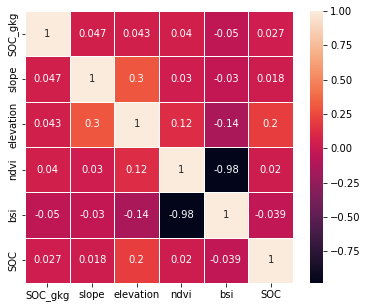

In [ ]:
# show the correlation matric for the dataset
corrMatrix = sampling_points.corr()
fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches
#sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data2 = scaler.fit_transform(sampling_points_2.drop('geometry', axis=1))
data2

array([[-0.75301283, -0.6177487 , -0.46185998, ..., -0.77307322,
         1.00857998, -1.39093647],
       [-0.82463762, -0.6177487 , -0.46185998, ..., -0.77307322,
         1.00857998, -1.39093647],
       [-0.69034113, -0.6177487 , -0.46185998, ..., -0.77307322,
         1.00857998, -1.39093647],
       ...,
       [ 2.52382131, -0.23611265, -1.03610637, ..., -0.82966933,
         1.00888554, -1.39093647],
       [-0.78882522, -0.19564765, -0.46931772, ..., -0.04309957,
         0.1342108 , -1.39093647],
       [-0.64557564, -0.68022264, -0.59609939, ...,  1.44779882,
        -1.34246167,  1.27160958]])

In [ ]:
df1 = pd.DataFrame(data=data2, columns=['SOC_gkg','slope','elevation','land_use','ndvi','bsi','SOC'])
df1.head()

,SOC_gkg,slope,elevation,land_use,ndvi,bsi,SOC
0,-0.753013,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
1,-0.824638,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
2,-0.690341,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
3,-0.376983,-0.617749,-0.461860,-0.819564,-0.773073,1.008580,-1.390936
4,0.921217,1.194339,1.231048,0.344566,1.857708,-1.770702,1.271610


<AxesSubplot:>

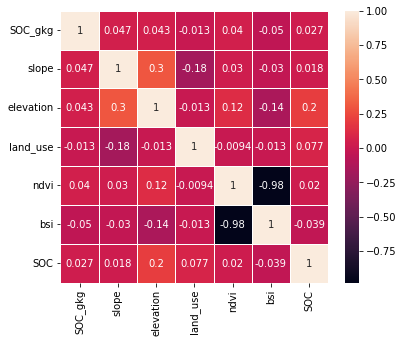

In [ ]:
# show the correlation matric for the dataset
corrMatrix = df1.corr()
fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches
#sns.heatmap(df.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

###  MACHINE LEARNING MODEL

* import the Ml libaries
* load the data
* split the data into dependent and independent variable
* splitt the dataset into training and test test
* Build our model uisng Random Forest Machine Learning Algorithm
* Check the accureacy of our model uisng differernt accracy metrics
* Plot the Predicted data
* Use the prediction  Probabaility output to create a raster map that shows probability of floodding across the study area

In [ ]:
# import require libaries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
#load the dataset 
sampling_points.head()

,SOC_gkg,slope,elevation,ndvi,bsi,SOC,geometry
0,1.3,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
2,0.5,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
3,2.0,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
4,5.5,0.222091,241.0,0.068141,-0.035617,1.0,POINT (-51.30944 -14.21444)
5,20.0,2.585801,468.0,0.477742,-0.393338,3.0,POINT (-52.80306 -14.51194)


In [ ]:
sampling_points.to_csv('extracted.csv',index=False)

In [ ]:
# Define the dependent variable that needs to be predicted (labels)
y = sampling_points["SOC_gkg"].values

# Define the independent variables. Let's also drop gemotry and label
x = sampling_points.drop(labels = ["SOC_gkg", "geometry"], axis=1) 
features_list = list(x.columns)  #List features so we can rank their importance later 

In [ ]:
import random
random.seed(42)
#Split data into train (60 %), validate (20 %) and test (20%) to verify accuracy after fitting the model.
# training data is used to train the model
# validation data is used for hyperparameter tuning
# testing data is used to test the model

X_train_val, X_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2,shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=42)

#### RANDOM FOREST REGRESSION

In [ ]:
# instantiate the Random Forest Model
model = RandomForestRegressor(n_estimators =1000, random_state = 42)

# Train the model on training data
model.fit(X_train, y_train)

# make prediction for the test dataset.
prediction = model.predict(X_test)

# The prediction SOC value
prediction[:10]

array([ 4.59193432,  8.86288379, 12.8210996 ,  3.85309554,  5.05213776,
       12.48945521,  2.63514694,  5.047127  , 14.02667072,  7.68878084])

In [ ]:
y_test[:10]

array([ 3.20000005,  2.9       ,  6.5       ,  1.29999995,  5.6       ,
        4.        , 15.        , 10.80000019, 17.1       ,  3.1       ])

In [ ]:
model.score(X_test,y_test)

-0.22408280175170048

#### Metric Evaluation

R2

In [ ]:
r2_score(X_test,y_test)

RMSE

MAE

In [ ]:
mae = mean_absolute_error(y_test,prediction)
mae

7.3714412713829445

Features Importance

slope        0.263337
bsi          0.235133
elevation    0.234677
ndvi         0.224342
land_use     0.042511
dtype: float64


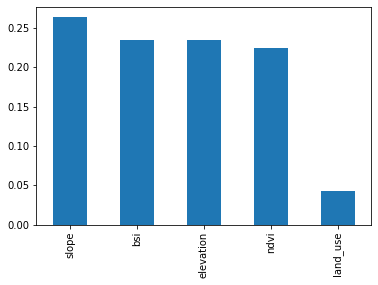

In [ ]:
# Estimate the feature importance
feature_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print(feature_imp)

# Plot the feature importance 
feature_imp.plot.bar();

Classification Accuracy

In [ ]:
# Calculate the accuracy score
accuracy = r2_score(y_test, prediction)

# Print the accuracy as a percentage
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: -23.07%


Generate 20000 new random points predictions points within the study
Extract all the values from the independent raster data to the predictive random points

In [ ]:
import random
random.seed(43)


,geometry
0,POINT (-61.19297 -10.59732)
1,POINT (-59.99078 -13.09619)
2,POINT (-56.46278 -12.71402)
3,POINT (-57.38471 -8.92853)
4,POINT (-55.39277 -9.96545)


In [ ]:
# we need to remove all the columns except the predictive features
predicitve_data = predictive_points.drop(labels = ["geometry"], axis=1)
predicitve_data.head()

,slope,elevation,land_use
0,0.523963,174.0,30.0
1,2.563251,599.0,40.0
2,0.738486,359.0,10.0
3,0.174526,154.0,10.0
4,0.678743,257.0,10.0


Finally, run the model on-some untrained data and present the results in a map